In [4]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Load your data
SFH_data = np.load('Latent data/SFHdata.npy')
labels_data = np.load('Latent data/labels_vectors.npy')
mass_sfr = np.load('Latent data/masspresentsfr.npy')

# Step 1: Split the data into train, validation, and test sets
SFH_train_val, SFH_test, labels_train_val, labels_test, mass_sfr_train_val, mass_sfr_test = train_test_split(
    SFH_data, labels_data, mass_sfr, test_size=0.2, random_state=42)

SFH_train, SFH_val, labels_train, labels_val, mass_sfr_train, mass_sfr_val = train_test_split(
    SFH_train_val, labels_train_val, mass_sfr_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 validation

# Step 2: Convert the data splits to tensors
SFH_train_tensor = torch.tensor(SFH_train, dtype=torch.float32)
SFH_val_tensor = torch.tensor(SFH_val, dtype=torch.float32)
SFH_test_tensor = torch.tensor(SFH_test, dtype=torch.float32)

labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.float32)

mass_sfr_train_tensor = torch.tensor(mass_sfr_train, dtype=torch.float32)
mass_sfr_val_tensor = torch.tensor(mass_sfr_val, dtype=torch.float32)
mass_sfr_test_tensor = torch.tensor(mass_sfr_test, dtype=torch.float32)

# Step 3: Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(SFH_train_tensor, labels_train_tensor, mass_sfr_train_tensor)
val_dataset = TensorDataset(SFH_val_tensor, labels_val_tensor, mass_sfr_val_tensor)
test_dataset = TensorDataset(SFH_test_tensor, labels_test_tensor, mass_sfr_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

device = torch.device("mps")
# Building an MLP model
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(16 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)  # Latent space
        
        # Decoder (Pathway 1)
        self.fc4 = nn.Linear(16, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 16 * 7)
        self.deconv1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2)

        # Pathway 2: MLP for simulation type classification
        self.fc_sim1 = nn.Linear(16, 100)
        self.fc_sim2 = nn.Linear(100, 100)
        self.fc_sim3 = nn.Linear(100, 10)
        
        # Pathway 3: MLP for SM and SFR prediction
        self.fc_sfr1 = nn.Linear(16, 200)
        self.fc_sfr2 = nn.Linear(200, 200)
        self.fc_sfr3 = nn.Linear(200, 200) 
        self.fc_sfr4 = nn.Linear(200, 2)  # Predicting SM and SFR

    def encoder(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 16 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = self.fc3(x)
        return encoded

    def decoder(self, x):
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = x.view(-1, 16, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        return x

    def sim_type_classifier(self, x):
        x = torch.relu(self.fc_sim1(x))
        x = torch.relu(self.fc_sim2(x))
        sim_type_output = self.fc_sim3(x)
        return sim_type_output

    def sfr_predictor(self, x):
        x = torch.relu(self.fc_sfr1(x))
        x = torch.relu(self.fc_sfr2(x))
        x = torch.relu(self.fc_sfr3(x))
        sfr_output = self.fc_sfr4(x)
        return sfr_output
    
    def forward(self, x):
        latent = self.encoder(x)
        
        # Pathway 1: Reconstruct SFH
        sfh_output = self.decoder(latent)
        
        # Pathway 2: Classify sim type
        sim_type_output = self.sim_type_classifier(latent)
        
        # Pathway 3: Predict SM and SFR
        sfr_output = self.sfr_predictor(latent)
        
        return sfh_output, sim_type_output, sfr_output


def compute_loss(sfh_output, sfh_target, sim_type_output, sim_type_target, mass_sfr_output, mass_sfr_target, w_reg, w_cl):
    mse_loss = nn.MSELoss()
    cross_entropy_loss = nn.CrossEntropyLoss()

    loss_sfh = mse_loss(sfh_output, sfh_target)
    loss_sim_type = cross_entropy_loss(sim_type_output, sim_type_target)
    loss_mass_sfr = mse_loss(mass_sfr_output, mass_sfr_target)

    total_loss = loss_sfh + w_reg * loss_mass_sfr + w_cl * loss_sim_type
    # print(f'Loss: {total_loss:.3f} | SFH Loss: {loss_sfh:.3f} | Sim Type Loss: {loss_sim_type:.3f} | Mass-SFR Loss: {loss_mass_sfr:.3f}')
    return total_loss, loss_sfh, loss_sim_type, loss_mass_sfr

AE = ConvAutoencoder().to(device)
print(AE)
optimizer = optim.Adam(AE.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
num_epochs = 500
losses = [] # To store training losses
losses_sfh = []  # To store SFH losses
losses_sim_type = []  # To store sim type losses
losses_mass_sfr = []  # To store mass-sfr losses
val_losses = []  # To store validation losses


for epoch in range(num_epochs):
    total_loss = 0.0
    for data in train_loader:
        inputs, sim_labels, mass_sfr = data
        optimizer.zero_grad()
        inputs = inputs.to(device)
        sim_labels = sim_labels.to(device)
        mass_sfr = mass_sfr.to(device)
        sfh_output, sim_type_output, mass_sfr_output = AE(inputs.unsqueeze(1))
        sfh_output = sfh_output.squeeze(1)
        loss = compute_loss(sfh_output, inputs, sim_type_output, sim_labels, mass_sfr_output, mass_sfr, 1, 1)
        loss = loss[0]
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    total_loss /= len(train_loader)
    losses.append(total_loss)
    
    # Validation phase
    AE.eval()
    val_loss = 0.0
    sfh_loss = 0.0
    sim_type_loss = 0.0
    mass_sfr_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, sim_labels, mass_sfr = data
            inputs = inputs.to(device)
            sim_labels = sim_labels.to(device)
            mass_sfr = mass_sfr.to(device)
            sfh_output, sim_type_output, mass_sfr_output = AE(inputs.unsqueeze(1))
            loss, loss_sfh, loss_sim_type, loss_mass_sfr = compute_loss(sfh_output, inputs, sim_type_output, sim_labels, mass_sfr_output, mass_sfr, 1, 1)
            val_loss += loss.item()
            sfh_loss += loss_sfh.item()
            sim_type_loss += loss_sim_type.item()
            mass_sfr_loss += loss_mass_sfr.item()
            
    
    val_loss /= len(val_loader)
    sfh_loss /= len(val_loader)
    sim_type_loss /= len(val_loader)
    mass_sfr_loss /= len(val_loader)
    val_losses.append(val_loss)
    losses_sfh.append(sfh_loss)
    losses_sim_type.append(sim_type_loss)
    losses_mass_sfr.append(mass_sfr_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Training Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, SFH Loss: {sfh_loss:.4f}, Sim Type Loss: {sim_type_loss:.4f}, Mass-SFR Loss: {mass_sfr_loss:.4f}')
    scheduler.step()

print('Training complete')
import matplotlib.pyplot as plt
plt.plot(losses_sfh, label='SFH Loss')
plt.plot(losses_sim_type, label='Sim Type Loss')
plt.plot(losses_mass_sfr, label='Mass-SFR Loss')
# show labels
plt.legend()
plt.title('Validation Losses')
# torch.save(AE, f'MultiModal/{16}loss{val_losses[-1]}.pth')
# np.save(f'MultiModal/{16}_losses_sfh.npy', val_losses)
# np.save(f'MultiModal/{16}_losses.npy', losses_sfh)
# np.save(f'MultiModal/{16}_losses_sim.npy', losses_sim_type)

ConvAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=112, bias=True)
  (deconv1): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv2): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv3): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(2,))
  (deconv4): ConvTranspose1d(16, 1, kernel_size=(

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([200, 139])) that is different to the input size (torch.Size([200, 1, 139])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22, 139])) that is different to the input size (torch.Size([22, 1, 139])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/500], Training Loss: 11.0839, Val Loss: 12.8421, SFH Loss: 10.8548, Sim Type Loss: 1.5895, Mass-SFR Loss: 0.3978
Epoch [10/500], Training Loss: 3.1287, Val Loss: 14.7094, SFH Loss: 14.1371, Sim Type Loss: 0.3230, Mass-SFR Loss: 0.2494
Epoch [20/500], Training Loss: 2.7149, Val Loss: 14.1799, SFH Loss: 13.8050, Sim Type Loss: 0.2288, Mass-SFR Loss: 0.1460
Epoch [30/500], Training Loss: 2.5597, Val Loss: 13.9296, SFH Loss: 13.5387, Sim Type Loss: 0.1989, Mass-SFR Loss: 0.1920
Epoch [40/500], Training Loss: 2.4927, Val Loss: 14.3184, SFH Loss: 13.9593, Sim Type Loss: 0.2046, Mass-SFR Loss: 0.1545
Epoch [50/500], Training Loss: 2.4132, Val Loss: 14.4687, SFH Loss: 14.1106, Sim Type Loss: 0.2212, Mass-SFR Loss: 0.1370
Epoch [60/500], Training Loss: 2.4826, Val Loss: 13.9797, SFH Loss: 13.5669, Sim Type Loss: 0.2818, Mass-SFR Loss: 0.1310
Epoch [70/500], Training Loss: 2.2939, Val Loss: 14.3970, SFH Loss: 14.0923, Sim Type Loss: 0.1909, Mass-SFR Loss: 0.1139
Epoch [80/500], Training

KeyboardInterrupt: 

Score for log stellar mass: 0.7952109575271606
Score for arcsinh SFR: 0.6872902512550354

RMSE for Stellar Mass: 0.2847140431404114 
RMSE for SFR: 0.36981046199798584

Baseline RMSE for Stellar Mass: 0.6291518807411194 (Predicting the mean) 
Baseline RMSE for SFR: 0.6613151431083679 (Predicting the mean)

1,5,10,50,90,95,99 Percentiles for mass residuals: [-0.83298862 -0.45108676 -0.31372185  0.03472519  0.29779816  0.41549997
  0.80535316]

1,5,10,50,90,95,99 Percentiles for SFR residuals: [-1.14039972 -0.44014286 -0.2058902   0.09866376  0.44544817  0.61603324
  1.02612268]


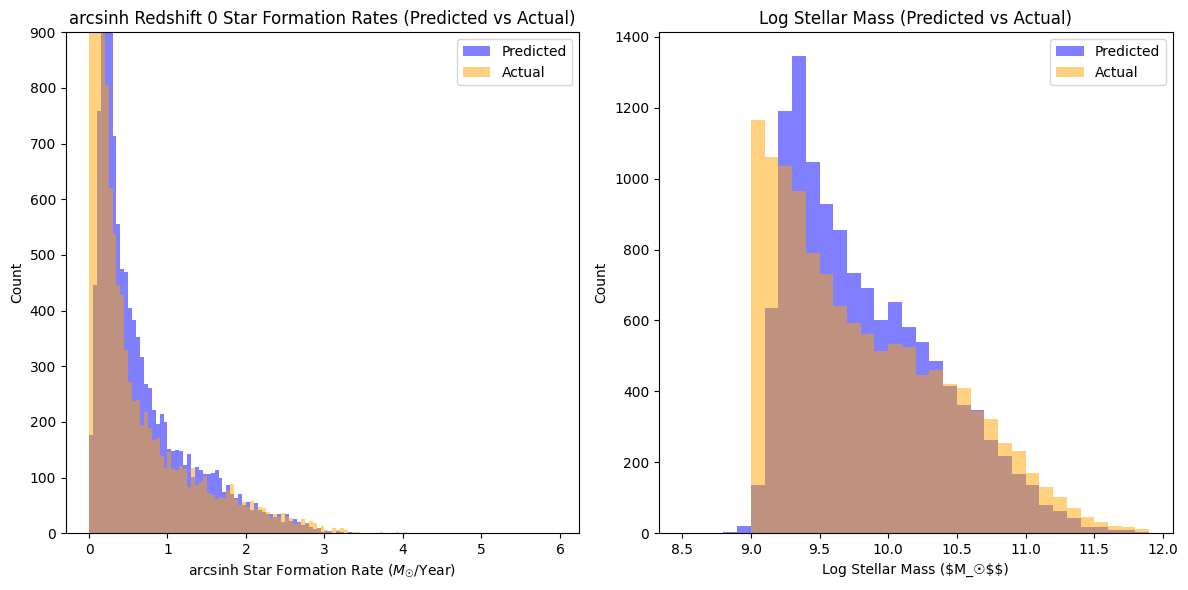

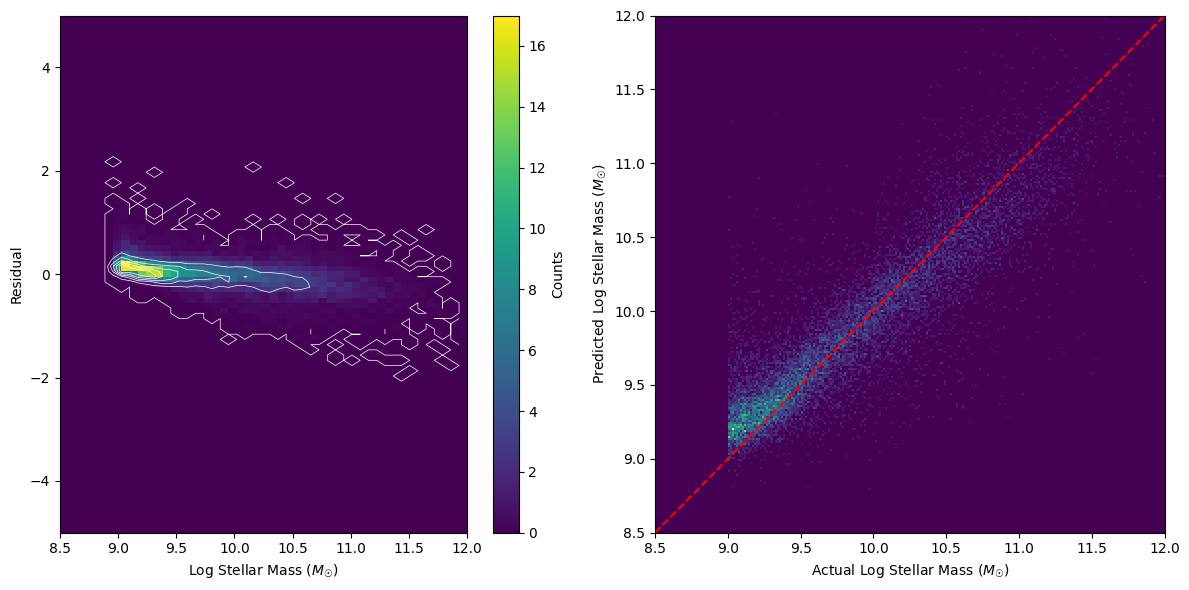

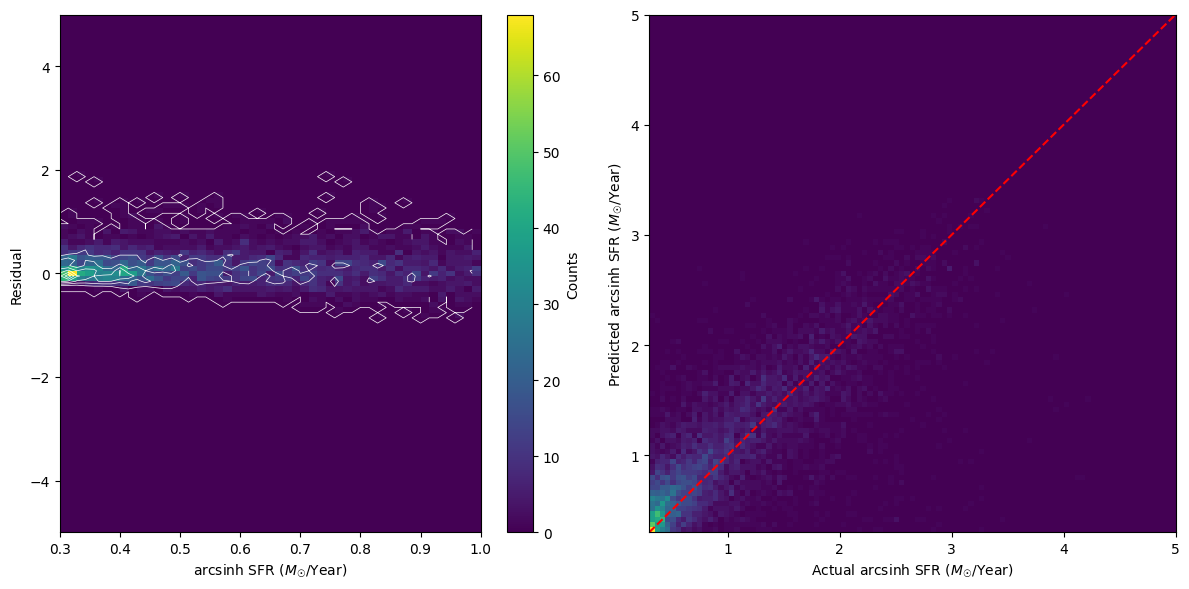

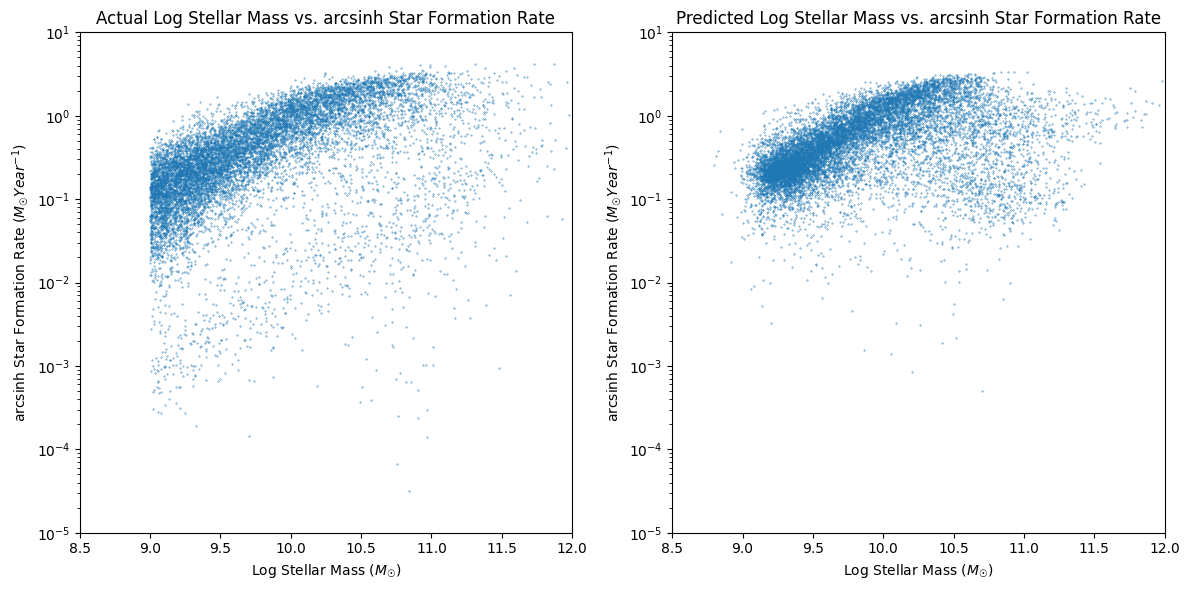

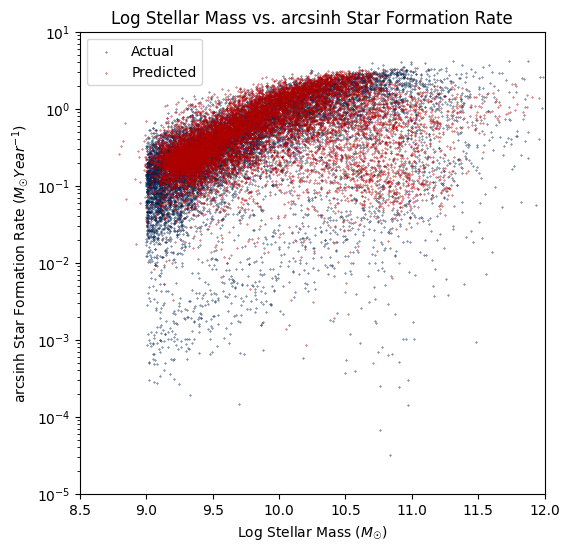

In [11]:
AE = torch.load('AE Models/multimodal2.pth')

from DataEval import pred_actual_data_eval, pred_actual_data_vis
with torch.no_grad():
    y_pred_tensor = AE(SFH_test_tensor.unsqueeze(1).to(device))

pred_sfh = y_pred_tensor[0]
pred_sim = y_pred_tensor[1]
pred_mass_sfr = y_pred_tensor[2]
pred_mass_sfr.shape, pred_sfh.shape
stellar_mass = mass_sfr_test_tensor.T[0].to(device)
star_formation_rate = mass_sfr_test_tensor.T[1].to(device)
labels = labels_test_tensor.to(device)

pred_mass = pred_mass_sfr.T[0].to(device)
pred_sfr = pred_mass_sfr.T[1].to(device)
pred_actual_data_eval(pred_mass.cpu(), pred_sfr.cpu(), stellar_mass.cpu(), star_formation_rate.cpu())
pred_actual_data_vis(pred_mass.cpu(), pred_sfr.cpu(), stellar_mass.cpu(), star_formation_rate.cpu())

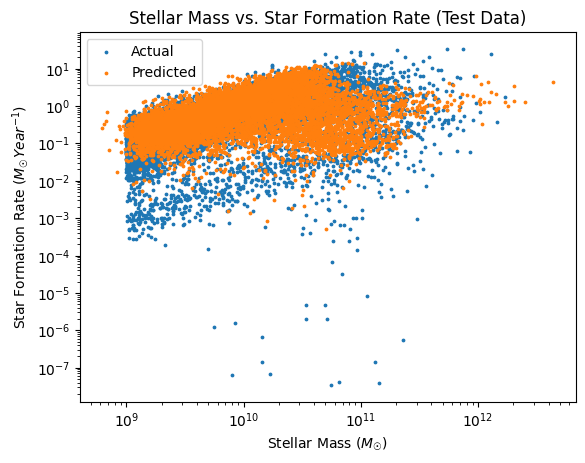

In [37]:
import matplotlib.pyplot as plt

plt.scatter(10**stellar_mass.cpu(), np.sinh(star_formation_rate.cpu()), s=3, alpha=1, label='Actual')
plt.scatter(10**pred_mass.cpu(), np.sinh(pred_sfr.cpu()), s=3, alpha=1, label='Predicted')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Stellar Mass ($M_\u2609$)')
plt.ylabel('Star Formation Rate ($M_\u2609 Year^{-1}$)')
plt.title('Stellar Mass vs. Star Formation Rate (Test Data)')
plt.legend()
plt.show()

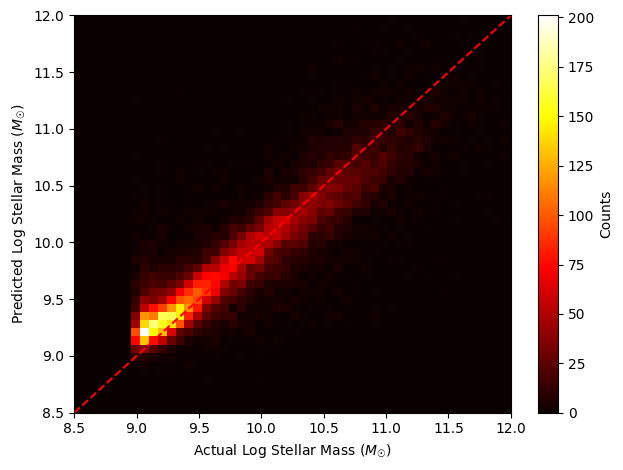

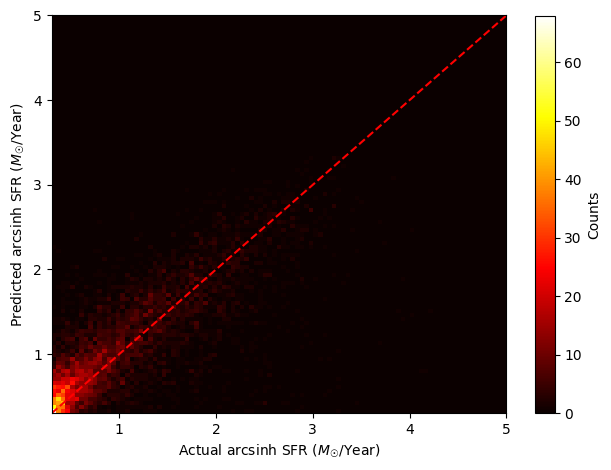

In [41]:
# Create a figure with two subplots
plt.figsize=(12, 6)
hist = plt.hist2d(stellar_mass.cpu().numpy(), pred_mass.cpu().numpy(), bins=[np.linspace(5, 12, 100), np.linspace(5, 12, 100)], cmap='hot')
plt.xlabel('Actual Log Stellar Mass ($M_\u2609$)')
plt.ylabel('Predicted Log Stellar Mass ($M_\u2609$)')
plt.ylim(8.5, 12)
plt.xlim(8.5, 12)
plt.plot([8.5, 12], [8.5, 12], color='red', linestyle='--')
cbar = plt.colorbar()
cbar.set_label('Counts')
plt.savefig("SM2dhists.pdf", format="pdf", bbox_inches="tight")

# Display the plots
plt.tight_layout()
plt.show()

# Create a figure with two subplots
plt.figsize=(12, 6)
hist = plt.hist2d(star_formation_rate.cpu().numpy(), pred_sfr.cpu().numpy(), bins=[np.linspace(0.3, 5, 100), np.linspace(0.3, 5, 100)], cmap='hot')
plt.xlabel('Actual arcsinh SFR ($M_\u2609$/Year)')
plt.ylabel('Predicted arcsinh SFR ($M_\u2609$/Year)')
plt.xlim(0.3,5)
plt.ylim(0.3,5)
plt.plot([0.3, 5], [0.3, 5], color='red', linestyle='--')
cbar = plt.colorbar()
cbar.set_label('Counts')
plt.savefig("SFR2dhists.pdf", format="pdf", bbox_inches="tight")

# Display the plots
plt.tight_layout()
plt.show()

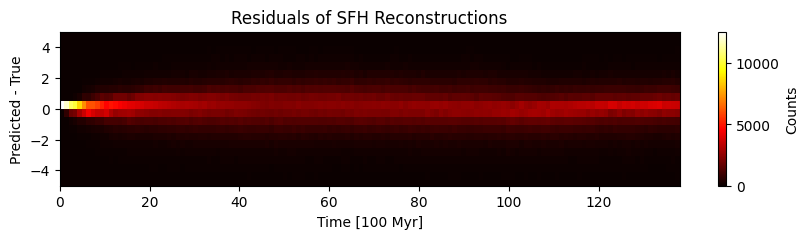

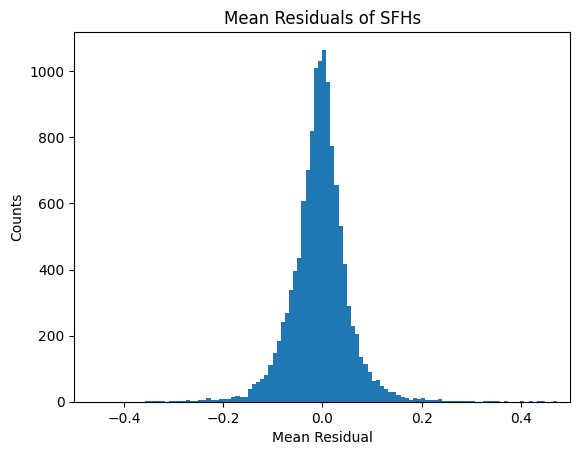

Mean sigma: 0.059
Mean residual: -0.005


In [46]:
real_SFHs = SFH_test_tensor.unsqueeze(1).to(device)
# Calculate residuals
residuals = (pred_sfh - real_SFHs).detach().cpu().numpy().squeeze()

# Create time axis
time_axis = np.tile(np.arange(residuals.shape[1]), residuals.shape[0])

# Flatten the residuals
residuals_flat = residuals.flatten()

# Create a 2D histogram
plt.figure(figsize=(10, 2))
plt.hist2d(time_axis, residuals_flat, bins=[139, 200], cmap='hot')
plt.ylim(-5,5)
plt.colorbar(label='Counts')
plt.xlabel('Time [100 Myr]')
plt.ylabel('Predicted - True')
plt.title('Residuals of SFH Reconstructions')
plt.savefig("SFH2dhist.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist([np.mean(residual) for residual in residuals], bins=150)
plt.xlabel('Mean Residual')
plt.ylabel('Counts')
plt.title('Mean Residuals of SFHs')
plt.xlim(-0.5, 0.5)
plt.show()

# Calculate sigma for the residuals
sigma = np.std([np.mean(residual) for residual in residuals])
# Calculate the mean of the stds
mean_sigma = np.mean(sigma)
print(f'Mean sigma: {mean_sigma:.3f}')
print(f'Mean residual: {np.mean([np.mean(residual) for residual in residuals]):.3f}')